In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

#loading the data

train_dataframe = pd.read_csv("../input/train.csv", sep=",")
Xsubm_dataframe = pd.read_csv("../input/test.csv", sep = ",")

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
print(train_dataframe.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


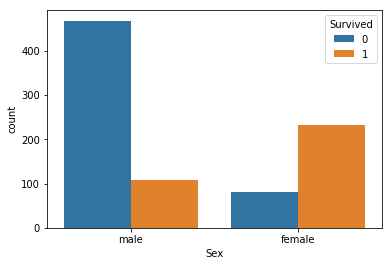

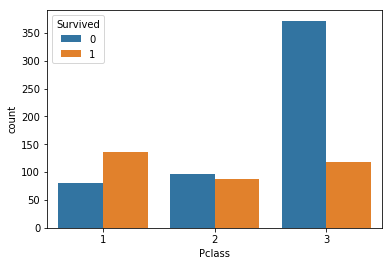

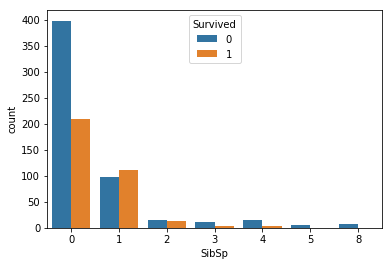

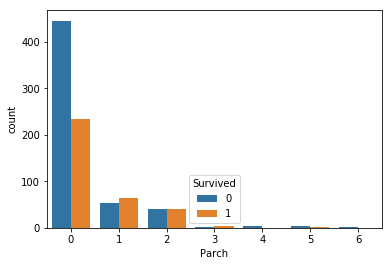

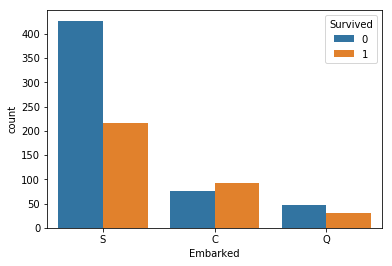

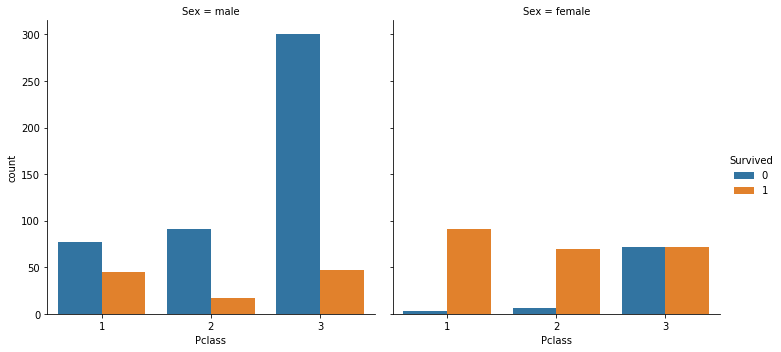

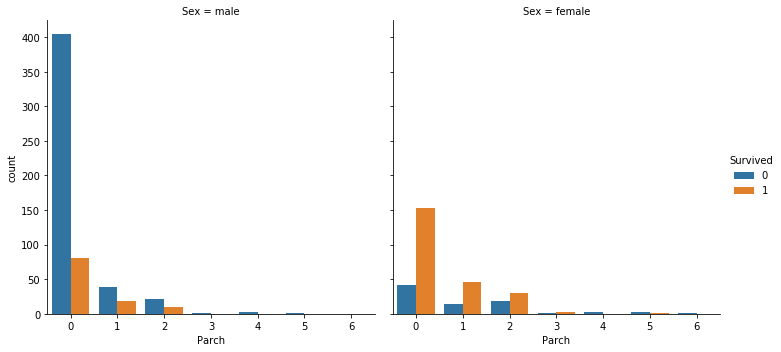

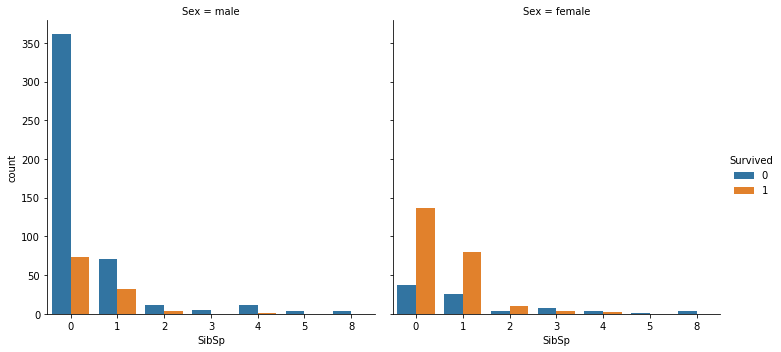

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


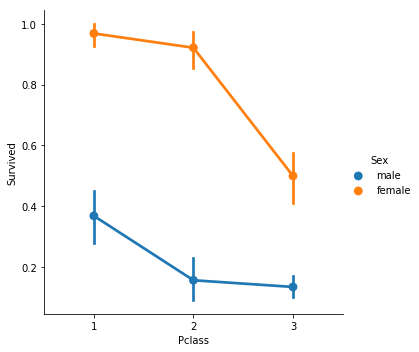

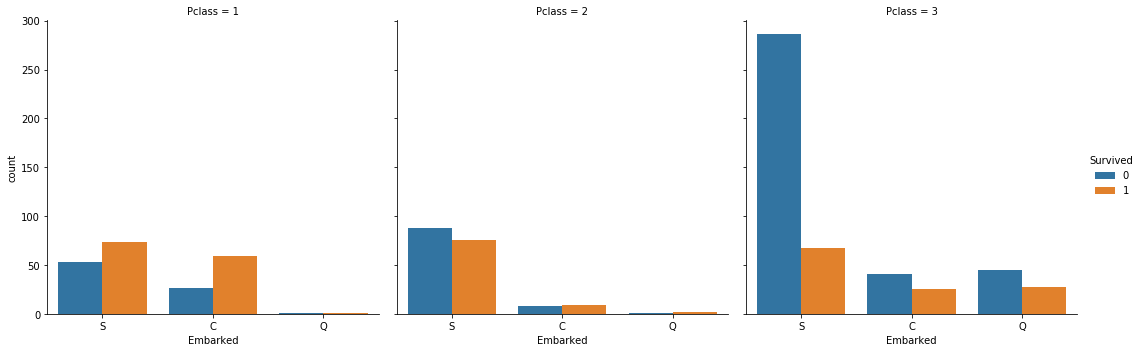

In [3]:
sns.countplot(x = "Sex", hue = "Survived", data = train_dataframe)
plt.show()
sns.countplot(x="Pclass", hue = "Survived", data = train_dataframe)
plt.show()
sns.countplot(x="SibSp", hue = "Survived", data = train_dataframe)
plt.show()
sns.countplot(x="Parch", hue = "Survived", data = train_dataframe)
plt.show()
sns.countplot(x="Embarked", hue = "Survived", data = train_dataframe)
plt.show()
sns.catplot(x = "Pclass", hue = "Survived", col = "Sex", kind = "count", data = train_dataframe)
plt.show()
sns.catplot(x = "Parch", hue = "Survived", col = "Sex", kind = "count", data = train_dataframe)
plt.show()
sns.catplot(x = "SibSp", hue = "Survived", col = "Sex", kind = "count", data = train_dataframe)
plt.show()
sns.catplot(x = 'Pclass',y = 'Survived', hue='Sex', data=train_dataframe, kind = "point") # equivalent to sns.pointplot
plt.show()
sns.catplot(x = 'Embarked',hue = 'Survived', col='Pclass', data=train_dataframe, kind = "count")
plt.show()

In [4]:
train_dataframe["Title"] = 0
train_dataframe["Title"] = train_dataframe.Name.str.extract("([a-zA-Z]+)\.")
Xsubm_dataframe["Title"] = 0
Xsubm_dataframe.Title = Xsubm_dataframe.Name.str.extract("([a-zA-Z]+)\.")

def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', "Sir"]:
        return 'Mr'
    elif title in ['Countess', 'Mme',"Dona"]:
        return 'Mrs'
    elif title in ['Mlle', 'Ms', "Lady"]:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

train_dataframe['Title']=train_dataframe.apply(replace_titles, axis=1)
Xsubm_dataframe['Title']=Xsubm_dataframe.apply(replace_titles, axis=1)

# here I use the compact title to infer the age. To have more "randomness", I estimate the
# unknown age with a normal distribution having mean and std drawn from the same "Title" category
for thistitle in list(set(train_dataframe.Title)):    
    row = (train_dataframe.Age.isnull())&(train_dataframe.Title == thistitle)    
    df = train_dataframe[train_dataframe.Title == thistitle]["Age"]    
    mu = df.mean()
    st = df.std() if len(df)>1 else 0        
    value = int(mu + st*np.random.randn(1))    
    train_dataframe.loc[row, "Age"] = value    

for thistitle in list(set(Xsubm_dataframe.Title)):
    row = (Xsubm_dataframe.Age.isnull())&(Xsubm_dataframe.Title == thistitle)
    mu = Xsubm_dataframe[Xsubm_dataframe.Title == thistitle]["Age"].mean()
    st = Xsubm_dataframe[Xsubm_dataframe.Title == thistitle]["Age"].std() if len(Xsubm_dataframe[Xsubm_dataframe.Title == thistitle]["Age"])>1 else 0    
    value = int(mu + st*np.random.randn(1))    
    Xsubm_dataframe.loc[row, "Age"] = value

title_reduced = list(set(train_dataframe.Title))
le_title = LabelEncoder()
le_title.fit(title_reduced)
train_dataframe["Title_LE"] = le_title.transform(train_dataframe.Title)
Xsubm_dataframe["Title_LE"] = le_title.transform(Xsubm_dataframe.Title)

In [5]:
age_max = max([train_dataframe.Age.max(), Xsubm_dataframe.Age.max()])
bins = np.linspace(0, age_max, 20)
train_dataframe.loc[:,"Age_bin"] = np.digitize(train_dataframe.Age, bins)
Xsubm_dataframe.loc[:,"Age_bin"] = np.digitize(Xsubm_dataframe.Age, bins)


# ### Add Fare category

# In[7]:


fare_max = max([train_dataframe.Fare.max(), Xsubm_dataframe.Fare.max()])
fare_bins = np.linspace(0, fare_max,10)
train_dataframe.loc[:,"Fare_bin"] = np.digitize(train_dataframe.Fare, fare_bins)
Xsubm_dataframe.loc[:, "Fare_bin"] = np.digitize(Xsubm_dataframe.Fare, fare_bins)

In [6]:
train_dataframe["Surname"]= 0
train_dataframe["Surname"]= train_dataframe.Name.str.extract("^(.+?),")

## Correcting the SibSp when possible

# Allison: looks like there is 1 Mrs. with 2 children
train_dataframe.loc[297,"SibSp"] = 1
train_dataframe.loc[297,"Parch"] = 1
train_dataframe.loc[305,"SibSp"] = 1
train_dataframe.loc[305,"Parch"] = 1
train_dataframe.loc[498,"SibSp"] = 0
train_dataframe.loc[498,"Parch"] = 2

# Andersson: one misidentified family members (they are not)
train_dataframe.loc[68, ["SibSp", "Parch"]] = [0,0]

# Backstrom
train_dataframe.loc[85,"SibSp"] = 1

In [7]:
# One-hot encoding for Sex
a = train_dataframe.loc[:,"Sex"] == "male"
train_dataframe.loc[:,"Male"] = a.astype(int)
train_dataframe.loc[:,"Female"] = (~a).astype(int)
a = Xsubm_dataframe.loc[:,"Sex"] == "male"
Xsubm_dataframe.loc[:,"Male"] = a.astype(int)
Xsubm_dataframe.loc[:,"Female"] = (~a).astype(int)

# One-hot encoding for Embark
embark = []
counter = 0
for i in train_dataframe.loc[:,"Embarked"]:
    if i not in embark:
        embark.append(i)

for p_embarked in embark:
    train_dataframe.loc[:,"Embarked_"+str(p_embarked)] = (train_dataframe.loc[:,"Embarked"] == p_embarked).astype(int)
    Xsubm_dataframe.loc[:,"Embarked_"+str(p_embarked)] = (Xsubm_dataframe.loc[:,"Embarked"] == p_embarked).astype(int)

train_dataframe.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_LE,Age_bin,Fare_bin,Surname,Male,Female,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,2,6,1,Braund,1,0,1,0,0,0


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [9]:
features = ["Pclass", "SibSp", "Parch", "Title_LE", "Age_bin", "Fare_bin", 
                "Male","Female", "Embarked_S", "Embarked_C","Embarked_Q","Embarked_nan"]

X = train_dataframe[features].values
Y  = train_dataframe.loc[:, "Survived"].values
Xsubm = Xsubm_dataframe[features].values

Xtrain, Xtest,Ytrain, Ytest = train_test_split(X, Y, test_size = 0.33)

In [10]:
C = np.logspace(-4,1,10)
tuned_parameters = [{"solver":["liblinear"],
                    "C": C,
                    "penalty":["l2","l1"]},
                   {"solver":["newton-cg"],
                    "C": C,
                    "penalty":["l2"]}]

scores = ["precision"]
for score in scores:
    print("Tuning hyperparameters for %s" % score)
    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv = 3,
                      scoring = "%s_macro" % score)
    clf.fit(Xtrain, Ytrain)   
    print("Best parameters found: {0}. Score {1}\n".format(clf.best_params_, clf.best_score_))        
    print("Grid scores on development set: \n")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
print(clf.best_estimator_)


Tuning hyperparameters for precision


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classificatio

Best parameters found: {'C': 0.016681005372000592, 'penalty': 'l2', 'solver': 'liblinear'}. Score 0.792947341997064

Grid scores on development set: 

0.312 (+/-0.001) for {'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}
0.312 (+/-0.001) for {'C': 0.0001, 'penalty': 'l1', 'solver': 'liblinear'}
0.312 (+/-0.001) for {'C': 0.00035938136638046257, 'penalty': 'l2', 'solver': 'liblinear'}
0.312 (+/-0.001) for {'C': 0.00035938136638046257, 'penalty': 'l1', 'solver': 'liblinear'}
0.312 (+/-0.002) for {'C': 0.001291549665014884, 'penalty': 'l2', 'solver': 'liblinear'}
0.312 (+/-0.001) for {'C': 0.001291549665014884, 'penalty': 'l1', 'solver': 'liblinear'}
0.773 (+/-0.017) for {'C': 0.004641588833612782, 'penalty': 'l2', 'solver': 'liblinear'}
0.312 (+/-0.001) for {'C': 0.004641588833612782, 'penalty': 'l1', 'solver': 'liblinear'}
0.793 (+/-0.066) for {'C': 0.016681005372000592, 'penalty': 'l2', 'solver': 'liblinear'}
0.312 (+/-0.001) for {'C': 0.016681005372000592, 'penalty': 'l1', 'solve

In [11]:
print("Scores on the train dataset")
print(classification_report(Ytrain, clf.best_estimator_.predict(Xtrain)))

print("Scores on the test dataset")
print(classification_report(Ytest, clf.best_estimator_.predict(Xtest)))
Ypred = clf.best_estimator_.predict(Xtest)
accuracy_dict = {}
accuracy_dict["logReg"] = [accuracy_score(Ytest, Ypred), clf.best_estimator_, ]
print("Accuracy: {0:.4g}%".format(accuracy_score(Ytest, Ypred)*100))

Scores on the train dataset
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       372
           1       0.88      0.43      0.58       224

   micro avg       0.77      0.77      0.77       596
   macro avg       0.81      0.70      0.71       596
weighted avg       0.79      0.77      0.74       596

Scores on the test dataset
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       177
           1       0.93      0.54      0.68       118

   micro avg       0.80      0.80      0.80       295
   macro avg       0.84      0.76      0.77       295
weighted avg       0.83      0.80      0.79       295

Accuracy: 80%
